In [29]:
import Environment_non_stationary
import Shop
from utilities import *
from mab.ucb_learner import *

In [30]:
shop_ts = Shop.Shop()
shop_c = Shop.Shop()

n_phases = 4
env = Environment_non_stationary.Environment(shop_ts.prices1, shop_ts.prices2, shop_ts.discounts, n_phases)

shop_ts.set_conv_rate(env.true_conv1, env.true_conv2)
shop_c.set_conv_rate(env.true_conv1, env.true_conv2)

price_arms = [(i, j) for i in range(len(shop_ts.prices1)) for j in range(len(shop_ts.prices2))]
n_price_arms = len(price_arms)

matching_arms = [(i, j, k, l) for i in range(len(shop_ts.prices1)) for j in range(len(shop_ts.prices2)) for k in range(shop_ts.n_classes) for l in range(len(shop_ts.discounts))]
n_matching_arms = len(matching_arms)

shop_ts.set_price_learner('TS', n_price_arms)
shop_ts.set_assignment_learner('TS', n_matching_arms)


days=365
frame_size = int(days / env.n_phases)
shop_ts.set_price_learner_sw('TS', n_price_arms, frame_size=frame_size, days=days)
shop_ts.set_assignment_learner_sw('TS', n_matching_arms, frame_size=frame_size, days=days)


In [31]:
generated_promo_ratios = np.array([0.4, 0.25, 0.2, 0.15])
max_ind_reward = max(env.prices1) + max(env.prices2)

In [32]:
env.true_conv1


array([[[0.6620964 , 0.49873383, 0.68567501, 0.02037327, 0.88953831],
        [0.02152026, 0.72076899, 0.94591646, 0.08434392, 0.10921053],
        [0.78049475, 0.41882082, 0.14253597, 0.14024696, 0.28776264],
        [0.99833081, 0.70907112, 0.62953791, 0.92869655, 0.38622797]],

       [[0.47760332, 0.97110286, 0.57316409, 0.12101882, 0.126069  ],
        [0.60360236, 0.94786223, 0.53981823, 0.24840876, 0.26496007],
        [0.69475107, 0.71296601, 0.6351105 , 0.24940412, 0.35492102],
        [0.88855868, 0.36445668, 0.6691788 , 0.40874715, 0.07858261]],

       [[0.15675506, 0.03444499, 0.22187032, 0.19833602, 0.90915668],
        [0.53173691, 0.49854898, 0.92896354, 0.6684    , 0.58830084],
        [0.44669744, 0.86369193, 0.75699162, 0.06521037, 0.23526123],
        [0.20383898, 0.46868763, 0.2446509 , 0.23386929, 0.80133544]],

       [[0.09645944, 0.01928567, 0.44981696, 0.39433199, 0.07714445],
        [0.21521003, 0.341226  , 0.56437812, 0.79185712, 0.99604385],
        [0.088

In [33]:
env.true_conv1[0]
# [phase x class x price]

array([[0.6620964 , 0.49873383, 0.68567501, 0.02037327, 0.88953831],
       [0.02152026, 0.72076899, 0.94591646, 0.08434392, 0.10921053],
       [0.78049475, 0.41882082, 0.14253597, 0.14024696, 0.28776264],
       [0.99833081, 0.70907112, 0.62953791, 0.92869655, 0.38622797]])

In [34]:
cr11 = np.array([[0.60, 0.51, 0.28, 0.23, 0.19],
       [0.82, 0.65 , 0.40, 0.30, 0.21],
       [0.80, 0.66, 0.60, 0.22 , 0.16],
       [0.91, 0.73, 0.69, 0.19, 0.12]])

In [35]:
cr12 = np.array([[0.60, 0.51, 0.38, 0.33, 0.29],
       [0.92, 0.80 , 0.65, 0.50, 0.45],
       [0.80, 0.66, 0.60, 0.42 , 0.37],
       [0.91, 0.73, 0.69, 0.49, 0.45]])

In [36]:
cr13 = np.array([[0.90, 0.81, 0.68, 0.53, 0.49],
       [0.82, 0.65 , 0.40, 0.30, 0.21],
       [0.70, 0.56, 0.40, 0.16 , 0.10],
       [0.91, 0.73, 0.69, 0.19, 0.12]])

In [37]:
cr14 = np.array([[0.70, 0.51, 0.28, 0.23, 0.19],
       [0.92, 0.65 , 0.40, 0.30, 0.21],
       [0.90, 0.66, 0.60, 0.22 , 0.16],
       [0.98, 0.83, 0.79, 0.59, 0.32]])

In [38]:
env.true_conv1[0] = cr11
env.true_conv1[1] = 1-cr11
env.true_conv1[2] = cr13
env.true_conv1[3] = 1-cr13

In [39]:
cr22 = np.array([[[0.65, 0.58, 0.48, 0.43, 0.29],
                [0.70, 0.68, 0.55, 0.50, 0.55],
                [0.75, 0.70, 0.60, 0.59, 0.40],
                [0.95, 0.88, 0.85, 0.80, 0.58]],

       [[0.72, 0.55 , 0.30, 0.28, 0.11],
        [0.75, 0.60 , 0.35, 0.33, 0.16],
        [0.82, 0.65 , 0.40, 0.38, 0.21],
        [0.85, 0.75 , 0.55, 0.52, 0.25]],

       [[0.80, 0.66, 0.60, 0.55 , 0.16],
        [0.84, 0.72, 0.66, 0.62 , 0.18],
        [0.89, 0.78, 0.70, 0.67 , 0.20],
        [0.95, 0.85, 0.79, 0.73 , 0.25]],

       [[0.91, 0.73, 0.69, 0.53, 0.12],
        [0.93, 0.76, 0.74, 0.64, 0.17],
        [0.96, 0.79, 0.78, 0.70, 0.25],
        [0.97, 0.83, 0.81, 0.77, 0.45]]])

In [40]:
cr21 = np.array([[[0.60, 0.51, 0.28, 0.23, 0.19],
                [0.65, 0.55, 0.35, 0.30, 0.25],
                [0.70, 0.60, 0.40, 0.35, 0.30],
                [0.90, 0.80, 0.75, 0.50, 0.38]],

       [[0.72, 0.55 , 0.30, 0.20, 0.11],
        [0.75, 0.60 , 0.35, 0.25, 0.16],
        [0.82, 0.65 , 0.40, 0.30, 0.21],
        [0.85, 0.75 , 0.55, 0.40, 0.25]],

       [[0.80, 0.66, 0.60, 0.22 , 0.16],
        [0.84, 0.72, 0.66, 0.28 , 0.18],
        [0.89, 0.78, 0.70, 0.38 , 0.20],
        [0.95, 0.85, 0.79, 0.58 , 0.25]],

       [[0.91, 0.73, 0.69, 0.19, 0.12],
        [0.93, 0.76, 0.74, 0.25, 0.17],
        [0.96, 0.79, 0.78, 0.40, 0.25],
        [0.97, 0.83, 0.81, 0.50, 0.45]]])

In [41]:
cr23 = np.array([[[0.60, 0.51, 0.48, 0.23, 0.19],
                [0.65, 0.55, 0.50, 0.30, 0.25],
                [0.70, 0.60, 0.55, 0.35, 0.30],
                [0.90, 0.80, 0.78, 0.50, 0.38]],

       [[0.72, 0.55 , 0.50, 0.20, 0.11],
        [0.75, 0.60 , 0.55, 0.25, 0.16],
        [0.82, 0.65 , 0.61, 0.30, 0.21],
        [0.85, 0.75 , 0.72, 0.40, 0.25]],

       [[0.80, 0.66, 0.64, 0.22 , 0.16],
        [0.84, 0.72, 0.69, 0.28 , 0.18],
        [0.89, 0.78, 0.75, 0.38 , 0.20],
        [0.95, 0.85, 0.83, 0.58 , 0.25]],

       [[0.91, 0.78, 0.75, 0.19, 0.12],
        [0.93, 0.82, 0.77, 0.25, 0.17],
        [0.96, 0.89, 0.84, 0.40, 0.25],
        [0.97, 0.93, 0.88, 0.50, 0.45]]])

In [42]:
cr24 = np.array([[[0.65, 0.58, 0.48, 0.33, 0.29],
                [0.70, 0.68, 0.55, 0.40, 0.55],
                [0.75, 0.70, 0.60, 0.55, 0.40],
                [0.95, 0.88, 0.85, 0.70, 0.58]],

       [[0.72, 0.55 , 0.30, 0.20, 0.11],
        [0.75, 0.60 , 0.35, 0.25, 0.16],
        [0.82, 0.65 , 0.40, 0.30, 0.21],
        [0.85, 0.75 , 0.55, 0.40, 0.25]],

       [[0.80, 0.66, 0.60, 0.22 , 0.16],
        [0.84, 0.72, 0.66, 0.28 , 0.18],
        [0.89, 0.78, 0.70, 0.38 , 0.20],
        [0.95, 0.85, 0.79, 0.58 , 0.25]],

       [[0.71, 0.53, 0.49, 0.10, 0.05],
        [0.73, 0.56, 0.54, 0.15, 0.10],
        [0.76, 0.59, 0.58, 0.22, 0.15],
        [0.77, 0.63, 0.61, 0.28, 0.17]]])

In [43]:
env.true_conv2[0] = cr21
env.true_conv2[1] = 1-cr21
env.true_conv2[2] = cr23
env.true_conv2[3] = 1-cr23

In [44]:
shop_c.set_expected_customers(np.array([25, 25, 25, 25]))
cec = shop_c.get_customer_list()
cep = shop_c.get_promo_list(generated_promo_ratios)

clairvoyant_promo_fractions = []
clairvoyant_p1s = []
clairvoyant_p2s = []
clairvoyant_p1_idxs = []
clairvoyant_p2_idxs = []
for i in range(env.n_phases):
    shop_c.set_conv_rate(env.true_conv1[i], env.true_conv2[i])

    cmt, cpa, cer, ers  = shop_c.get_clairvoyant_prices_and_matching(cec, cep, 5, 5)
    cp1idx = price_arms[cpa][0]
    cp2idx = price_arms[cpa][1]
    cp1 = env.prices1[cp1idx]
    cp2 = env.prices2[cp2idx]

    cpf = shop_c.get_promo_fractions_from_tuples(cmt)

    clairvoyant_promo_fractions.append(cpf)
    clairvoyant_p1s.append(cp1)
    clairvoyant_p2s.append(cp2)
    clairvoyant_p1_idxs.append(cp1idx)
    clairvoyant_p2_idxs.append(cp2idx)


In [45]:
clairvoyant_promo_fractions

[array([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.4, 0.6],
        [0.6, 0. , 0.4, 0. ],
        [1. , 0. , 0. , 0. ]]),
 array([[1. , 0. , 0. , 0. ],
        [0.4, 0. , 0. , 0.6],
        [0.2, 0. , 0.8, 0. ],
        [0. , 1. , 0. , 0. ]]),
 array([[0.4, 0. , 0. , 0.6],
        [0.2, 0. , 0.8, 0. ],
        [0. , 1. , 0. , 0. ],
        [1. , 0. , 0. , 0. ]]),
 array([[0.4, 0. , 0. , 0.6],
        [1. , 0. , 0. , 0. ],
        [0.2, 0. , 0.8, 0. ],
        [0. , 1. , 0. , 0. ]])]

In [46]:
ts_rewards_per_day = []
ts_sw_rewards_per_day = []
c_rewards_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])

for day in range(days):
    if day == 0:
        shop_ts.set_expected_customers(customers_ie)
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))

    # 2-step learner with no sliding window
    price_arm_idx_ts = shop_ts.price_learner.pull_arm()

    price1idx_ts = price_arms[price_arm_idx_ts][0]
    price2idx_ts = price_arms[price_arm_idx_ts][1]
    price1_ts = env.prices1[price_arms[price_arm_idx_ts][0]]
    price2_ts = env.prices2[price_arms[price_arm_idx_ts][1]]

    expected_customers_ts = shop_ts.get_customer_list()
    expected_promos_ts = shop_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_ts = shop_ts.assignment_learner.pull_arm_matching(expected_customers_ts, expected_promos_ts, matching_arms, price1idx_ts, price2idx_ts)
    promo_fractions_ts = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts)

    # 2-step learner with sliding window
    price_arm_idx_ts_sw = shop_ts.price_learner_sw.pull_arm(day)

    price1idx_ts_sw = price_arms[price_arm_idx_ts_sw][0]
    price2idx_ts_sw = price_arms[price_arm_idx_ts_sw][1]
    price1_ts_sw = env.prices1[price_arms[price_arm_idx_ts_sw][0]]
    price2_ts_sw = env.prices2[price_arms[price_arm_idx_ts_sw][1]]

    expected_customers_ts_sw = shop_ts.get_customer_list()
    expected_promos_ts_sw = shop_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_ts_sw = shop_ts.assignment_learner_sw.pull_arm_matching(expected_customers_ts_sw, expected_promos_ts_sw, matching_arms, day, price1idx_ts_sw, price2idx_ts_sw)
    promo_fractions_ts_sw = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts_sw)

    # simulate the day
    env.generate_next_day_customers()

    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    revenue_ts = []
    revenue_ts_sw = []
    revenue_c = []

    ts_total_reward = 0
    ts_sw_total_reward = 0

    c_count = 0

    phase = env.get_phase(days) % env.n_phases
    
    for cust in customers:

        selected_promo_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts[cust])
        selected_promo_ts_sw = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts_sw[cust])
        selected_promo_c = np.random.choice([0, 1, 2, 3], 1, p=clairvoyant_promo_fractions[phase][cust])

        ts_buy1 = env.round1(cust, price1_ts, days)
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = env.round2(cust, selected_promo_ts, price2_ts, days)

        c_buy1 = env.round1(cust, clairvoyant_p1s[phase], days)
        c_buy2 = 0
        if c_buy1:
            c_buy2 = env.round2(cust, selected_promo_c, clairvoyant_p2s[phase], days)

        ts_sw_buy1 = env.round1(cust, price1_ts_sw, days)
        ts_sw_buy2 = 0
        if ts_sw_buy1:
            ts_sw_buy2 = env.round2(cust, selected_promo_ts_sw, price2_ts_sw, days)

        ts_ind_reward = ts_buy1*price1_ts + ts_buy2*price2_ts*(1-shop_ts.discounts[selected_promo_ts])
        ts_sw_ind_reward = ts_sw_buy1*price1_ts_sw + ts_sw_buy2*price2_ts_sw*(1-shop_ts.discounts[selected_promo_ts_sw])
        c_ind_reward = c_buy1*clairvoyant_p1s[phase] + c_buy2*clairvoyant_p2s[phase]*(1-shop_c.discounts[selected_promo_c])

        norm_ts_ind_reward = ts_ind_reward / max_ind_reward
        norm_ts_sw_ind_reward = ts_sw_ind_reward / max_ind_reward

        # update 2-step learner with no sliding window
        shop_ts.price_learner.update(price_arm_idx_ts, norm_ts_ind_reward)

        matching_arm_index_ts = matching_arms.index((price1idx_ts, price2idx_ts, cust, selected_promo_ts))
        shop_ts.assignment_learner.update(matching_arm_index_ts, norm_ts_ind_reward)

        # update 2-step learner with sliding window
        shop_ts.price_learner_sw.update(price_arm_idx_ts_sw, norm_ts_sw_ind_reward, day)

        matching_arm_index_ts_sw = matching_arms.index((price1idx_ts_sw, price2idx_ts_sw, cust, selected_promo_ts_sw))
        shop_ts.assignment_learner_sw.update(matching_arm_index_ts_sw, norm_ts_sw_ind_reward, day)

        revenue_ts.append(ts_ind_reward)
        revenue_ts_sw.append(ts_sw_ind_reward)
        revenue_c.append(c_ind_reward)
    
    shop_ts.price_learner_sw.end_of_day(day)
    shop_ts.assignment_learner_sw.end_of_day(day)

    """print("DAY:", day)
    print("SW Pulled Arm:", )
    print("***********NO SW*****************")
    print(shop_ts.price_learner.beta_parameters)
    print("**************SW*****************")
    print(shop_ts.price_learner_sw.beta_parameters)
    print()"""

    ts_rewards_per_day.append(np.mean(revenue_ts))
    ts_sw_rewards_per_day.append(np.mean(revenue_ts_sw))
    c_rewards_per_day.append(np.mean(revenue_c))
    



Text(0, 0.5, 'Revenue')

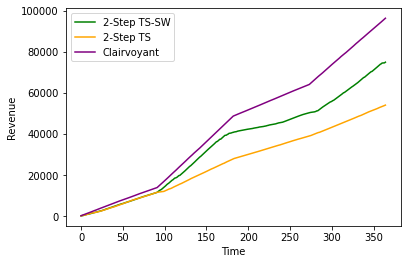

In [47]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(ts_sw_rewards_per_day), color='green', label='2-Step TS-SW')
plt.plot(np.cumsum(ts_rewards_per_day), color='orange', label='2-Step TS')
plt.plot(np.cumsum(c_rewards_per_day), color='purple', label='Clairvoyant')
#plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='red', label='2-step TS')
#plt.plot(np.cumsum(big_ts_rewards_per_class_per_day), color='blue', label='Big TS')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

Text(0, 0.5, 'Regret')

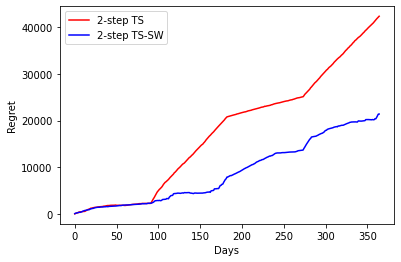

In [48]:
plt.plot(np.cumsum(np.array(c_rewards_per_day) - np.array(ts_rewards_per_day)), color='red', label='2-step TS')
plt.plot(np.cumsum(np.array(c_rewards_per_day) - np.array(ts_sw_rewards_per_day)), color='blue', label='2-step TS-SW')
#plt.plot(np.cumsum(np.array(calt_rewards_per_class_per_day) - np.array(small_ts_rewards_per_class_per_day)), color='purple', label='2-step TS')
#plt.plot(np.cumsum(np.array(calt_rewards_per_class_per_day) - np.array(u_rewards_per_class_per_day)), color='green', label='Big TS')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')

In [19]:
n_matching_arms

400

In [34]:
env.true_conv1

array([[[0.19606042, 0.3100063 , 0.46036076, 0.37415018, 0.95044869],
        [0.19903579, 0.73274992, 0.06723265, 0.50658375, 0.52928321],
        [0.44593867, 0.96512953, 0.13178814, 0.48679432, 0.79298463],
        [0.06032619, 0.34690037, 0.59989951, 0.40608334, 0.9303367 ]],

       [[0.86114131, 0.51686439, 0.17821929, 0.56348818, 0.90651157],
        [0.47535154, 0.32014764, 0.01931189, 0.68386713, 0.72780363],
        [0.55559167, 0.89736261, 0.61626043, 0.37671711, 0.41272453],
        [0.22522836, 0.38246496, 0.89011743, 0.73485606, 0.17291941]],

       [[0.44968627, 0.70651718, 0.32132595, 0.78166298, 0.69931253],
        [0.44017025, 0.94361671, 0.40397476, 0.90820594, 0.96629764],
        [0.03449903, 0.68163441, 0.46698768, 0.57580324, 0.22719535],
        [0.88394887, 0.0298646 , 0.99680638, 0.40665125, 0.72913718]],

       [[0.84434553, 0.17003467, 0.53103698, 0.29313487, 0.74725969],
        [0.7901446 , 0.32852785, 0.63712467, 0.32886732, 0.16991268],
        [0.312